<h2 align=center> Classify Radio Signals from Outer Space with Keras</h2>

![](Allen_Telescope.jpg)
[Allen Telescope Array](https://flickr.com/photos/93452909@N00/5656086917) by [brewbooks](https://www.flickr.com/people/93452909@N00) is licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/)

## Task 1: Import Libraries

In [1]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Preprocess SETI Data

In [4]:
'''
The data consists of train and val sets. The images.csv file is a csv file containing
normalised pixel intensity values for spectrogram images.

The labels have been stored as 1-hot vectors in a csv file. There are 4 classes

'''
train_images = pd.read_csv("dataset/train/images.csv", header=None)
train_labels = pd.read_csv("dataset/train/labels.csv", header=None)

val_images = pd.read_csv("dataset/validation/images.csv", header=None)
val_labels = pd.read_csv("dataset/validation/labels.csv", header=None)

In [9]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [8]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [14]:
'''
Note: Here, our image shape is 8192. This is because our images are a matrix of shape
64px width * 128px height. (Note: 8192=64*128)

Thus, we will have to reshape the array.
'''

print(f"Training set shape = {train_images.shape} and {train_labels.shape}")
print(f"Val set shape = {val_images.shape} and {val_labels.shape}")

Training set shape = (3200, 8192) and (3200, 4)
Val set shape = (800, 8192) and (800, 4)


In [19]:
x_train = train_images.values.reshape(3200,64,128,1) #(No. of samples, width, height, channels)
x_val = val_images.values.reshape(800,64,128,1)   #Note that there is only 1 channel 

y_train = train_labels.values
y_val = val_labels.values

## Task 3: Plot 2D Spectrograms

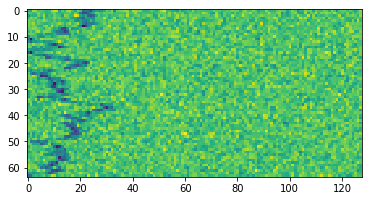

In [26]:
img = np.squeeze(x_train[0])  #Plot first img
plt.imshow(img)
plt.show()

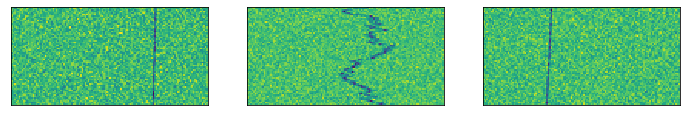

In [28]:
#Plot any random 3 spectrograms from train set
plt.figure(0, figsize = (12,12))
for i in range(1,4):
    plt.subplot(1, 3, i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

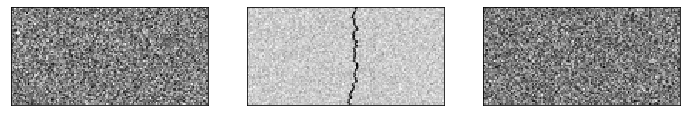

In [32]:
#The colour means nothing, we need to make it greyscale

#Plot any random 3 spectrograms from train set
plt.figure(0, figsize = (12,12))
for i in range(1,4):
    plt.subplot(1, 3, i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

## Task 4: Create Training and Validation Data Generators: Augmentation

In [34]:
# We'll only randomly flip images horizontally. Do experiment more.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
ImageDataGenerator?

In [38]:
datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_train)

## Task 5: Creating the CNN Model

In [40]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [42]:
# Initialising the CNN
model = Sequential()
# 1st Convolution
model.add(Conv2D(32, (5,5), padding='same', input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

#Ouptut layer
model.add(Dense(4, activation="softmax"))

## Task 6: Learning Rate Scheduling and Compile the Model

In [46]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = 5,
    decay_rate = 0.96,
    staircase = True
)
optimizer = Adam(learning_rate = lr_schedule)

In [47]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)       

## Task 7: Training the Model

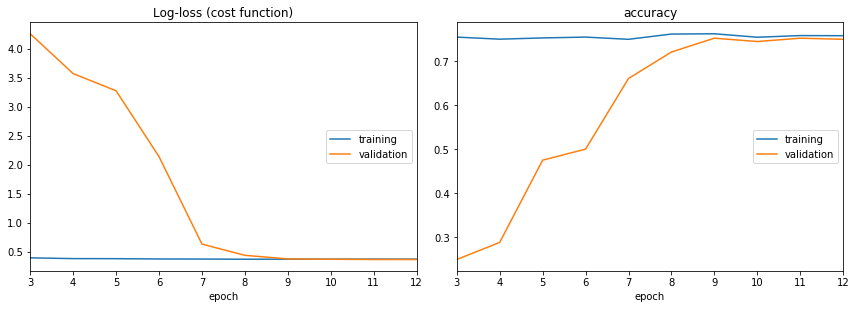

Log-loss (cost function):
training   (min:    0.368, max:    0.611, cur:    0.370)
validation (min:    0.363, max:    4.256, cur:    0.363)

accuracy:
training   (min:    0.685, max:    0.761, cur:    0.757)
validation (min:    0.250, max:    0.751, cur:    0.749)
100/100 [==============================] - 9s 88ms/step - loss: 0.3700 - accuracy: 0.7569 - val_loss: 0.3634 - val_accuracy: 0.7487


In [50]:
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", mode="min")

callbacks = [PlotLossesCallback(), checkpoint]

batch_size=32

history=model.fit(
    datagen_train.flow(x_train,y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch = len(x_train) // batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size),
    validation_steps = len(x_val) // batch_size,
    epochs = 12,
    callbacks=callbacks
)

This can be optimized more by hyperparameter tuning and transfer learning.

## Task 8: Model Evaluation

In [51]:
model.evaluate(x_val, y_val)

800/800 [==============================] - 1s 638us/sample - loss: 0.3639 - accuracy: 0.7513


[0.3639062727370765, 0.75125]

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

In [ ]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);